# Solution of the Regge-Wheeler equation 

In [7]:
import numpy as np
from scipy.interpolate import interp1d
import math
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 12})
from matplotlib.animation import FuncAnimation
from constants import *
from RK import *

### Defining the r(r*) equation

In [2]:
def rstar(r):
    return r + 2 * np.log(r/2 - 1)

rlist1 = np.linspace(2.0000000000001,2.000000001,800)
rlist2 = np.linspace(2.0000000002,2.00001,800)
rlist3 = np.linspace(2.0002,2.01,2000)
rlist4 = np.linspace(2.02,300,8000)
rlist = [*rlist1, *rlist2, *rlist3, *rlist4]

rstarlist = []
nlst = []
for i in range(len(rlist)):
    rstarlist.append(rstar(rlist[i]))
    nlst.append(i)
    
rinf1 = np.linspace(-460,-59.25510597382537,850)    
rinf2 = np.linspace(2 + 10**(-100), 2.0000000000001, 850)

rfinal1 = [*rinf1, *rstarlist]
rfinal2 = [*rinf2, *rlist]

r_of_rt = interp1d(rfinal1, rfinal2)

### Seting initial conditions

In [3]:
def gaussian(rt, rt0, sigma):
    gaussianf = math.exp(-(rt - rt0)**2 / sigma**2)
    return gaussianf

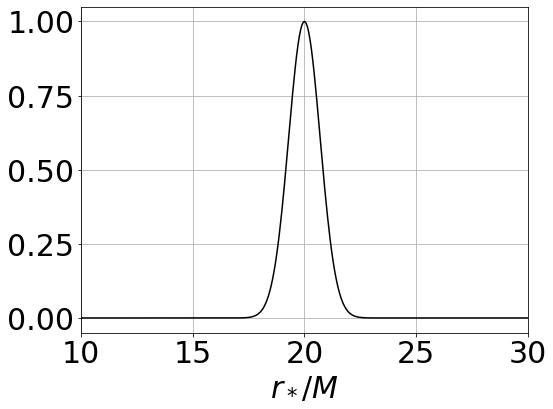

In [4]:
%matplotlib inline

rt = np.linspace(-300,300,10000)
gauss = []
for i in range(len(rt)):
    gauss.append(gaussian(rt[i], 20, 1))

plt.figure(figsize = (8, 6))
plt.plot(rt, gauss, color="Black")
plt.xlabel(r"$r_*/M$", fontsize=30)
plt.xlim(10, 30)
plt.tick_params(axis='both', labelsize=30)
plt.grid()

In [5]:
def set_initial_data(rt, rt0, sigma):
    """
    Input
    ----------
    rt: array / spatial grid
    r0: radius establishes the radius where the Gaussian is centered
    sigma: establishes the Gaussian diameter
    ----------
    Output
    -------
    u_in: initial condition
    """

    nr = len(rt)
    RW = np.zeros(nr)
    RW_dot = np.zeros(nr)        
    
    for i in range(nr):
        RW[i] = gaussian(rt[i], rt0, sigma)
        RW_dot[i] = 0
        
    uin = np.block([[RW], [RW_dot]]).T
    
    return uin

### Seting up the RW equation

In [6]:
def rhs_RW(t, u, rt, l):
    """
    Input
    ----------
    u : numpy.array: (S, dS/dt, F, dF/dt, H, dH/dt)
    l: harmonic index (integer)
    M: Total mass (integer)
    r: array / spatial grid
    rt: array / spatial grid - tortoise coordinates   
    ----------
    Output
    -------
    rhs : numpy.array right hand side: du/dt = rhs
    """
    
    RW = u.T[0]
    RW_dot = u.T[1]
    
    nr = len(RW)
    
    rhs = np.empty((nr, 2))
    
    drt = rt[1] - rt[0]
    
    rhs[0] = np.array([(RW[1] - RW[0])/drt, # Boundary condition!
                      (- RW[3] + 4*RW[2] - 5*RW[1] + 2*RW[0]) / (drt ** 2)-
                      ((1-2/r_of_rt(rt[0]))*((l*(l+1)) / (r_of_rt(rt[0])**2) - 6 / (r_of_rt(rt[0])**3))*RW[0])])
    
    rhs[-1] = np.array([-(RW[-1] - RW[-2]) / drt, # Boundary condition!
                       (2*RW[-1] - 5*RW[-2] + 4*RW[-3] - RW[-4]) / (drt ** 2) -
                       ((1-2/r_of_rt(rt[-1]))*((l*(l+1)) / (r_of_rt(rt[-1])**2) - 6 / (r_of_rt(rt[-1])**3))*RW[-1])])
    
    for i in range(nr-1):
        rhs[i] = np.array([RW_dot[i],
                           (RW[i+1] - 2 * RW[i] + RW[i-1]) / (drt ** 2) -
                           ((1-2/r_of_rt(rt[i]))*((l*(l+1)) / (r_of_rt(rt[i])**2) - 6 / (r_of_rt(rt[i])**3))*RW[i])])
        
    return rhs    

### Solving the RW equation

In [8]:
%matplotlib inline
import matplotlib
from matplotlib import animation
matplotlib.rc('animation', html='html5')

def solveRW(l, sigma, rt0, nt):
    """
    Input
    ----------
    l: harmonic index (integer)
    r0: radius establishes the radius where the Gaussian is centered
    sigma: establishes the Gaussian diameter
    nt: Number of points of temporal grid
    ----------
    Output
    -------
    ani: animation evolution of perturbation equations
    """
    
    # Defining Grid
    
    rt = np.linspace(-300,300,2000)
    nr = len(rt)
    drt = rt[1] - rt[0]
    dt = 0.8*drt
    
    # Setting initial conditions
    
    uin = set_initial_data(rt, rt0, sigma)
    
    RWevol = np.zeros((nt, nr))
    RWevol[0] = uin.T[0]
    
    # Setting up the RW potencial
    
    RWP = np.zeros(nr)
    ZP = np.zeros(nr)
    
    alpha = (l-1)*(l+2)/2
    
    for i in range(nr):
        RWP[i] = (1-2/r_of_rt(rt[i]))*((l*(l+1)) / (r_of_rt(rt[i])**2) - 6 / (r_of_rt(rt[i])**3))
        ZP[i] = (1-2/r_of_rt(rt[i]))*(2*alpha**2*(alpha+1)*r_of_rt(rt[i])**3+6*alpha**2*r_of_rt(rt[i])**2+18*alpha*r_of_rt(rt[i])+18)/(r_of_rt(rt[i])**3*(alpha*r_of_rt(rt[i])+3)**2)
    
    # Evolving RW equation
    
    u = np.copy(uin)
    uaux = np.copy(uin)
    
    robs = 100
        
    index_robs = min(range(len(rt)), key=lambda i: abs(rt[i]-robs)) 
    
    RWobs = np.zeros(nt + 1)   
    RWobs[0] = rhs_RW(1, u, rt, l)[index_robs][0]        
      
    for n in range(nt):
        uaux = rk4_step(n*dt, u, dt, rhs_RW, rt, l)        
        
        if np.any(np.isnan(uaux)):
            break    
            
        u = uaux    
        
        RWevol[n] = u.T[0]
        
        RWobs[n+1] = u.T[0][index_robs]  
        
    # Generating the animation    
    
    N_plots = nr
        
    fig = plt.figure(figsize = (12, 8))    
    
    ax = plt.axes(xlim=(-20,100), ylim=(-0.35,1.25))
    graphRW, = ax.plot([], [], color="darkorange", label = r"$\bar{t} = $", linewidth=4.5)
    L = plt.legend(loc="upper right")
    graphRWP, = ax.plot([], [], color="red",linewidth=4)
    plt.xlabel(r"$\bar{r}_*$", fontsize=40)
    plt.grid(color="dimgray")
    ax.set_facecolor("Black")
    plt.tick_params(axis='both', labelsize=35)
           
    def animate1(i):
        lab = r"$\bar{t} = $" + str(round(i * dt, 4)) 
        graphRW.set_data(rt, RWevol[i])
        L.get_texts()[0].set_text(lab)
        L.get_texts()[0].set_fontsize(40) 
        return graphRW
    
    def animate2(i):
        graphRWP.set_data(rt, RWP)
        return graphRWP,
          
    ani1 = FuncAnimation(fig, animate1, interval=100, frames=nt) 
    ani2 = FuncAnimation(fig, animate2, interval=100, frames=nt) 
    
        
    return ani1, ani2, RWobs, dt, rt, RWP, ZP

<IPython.core.display.Javascript object>


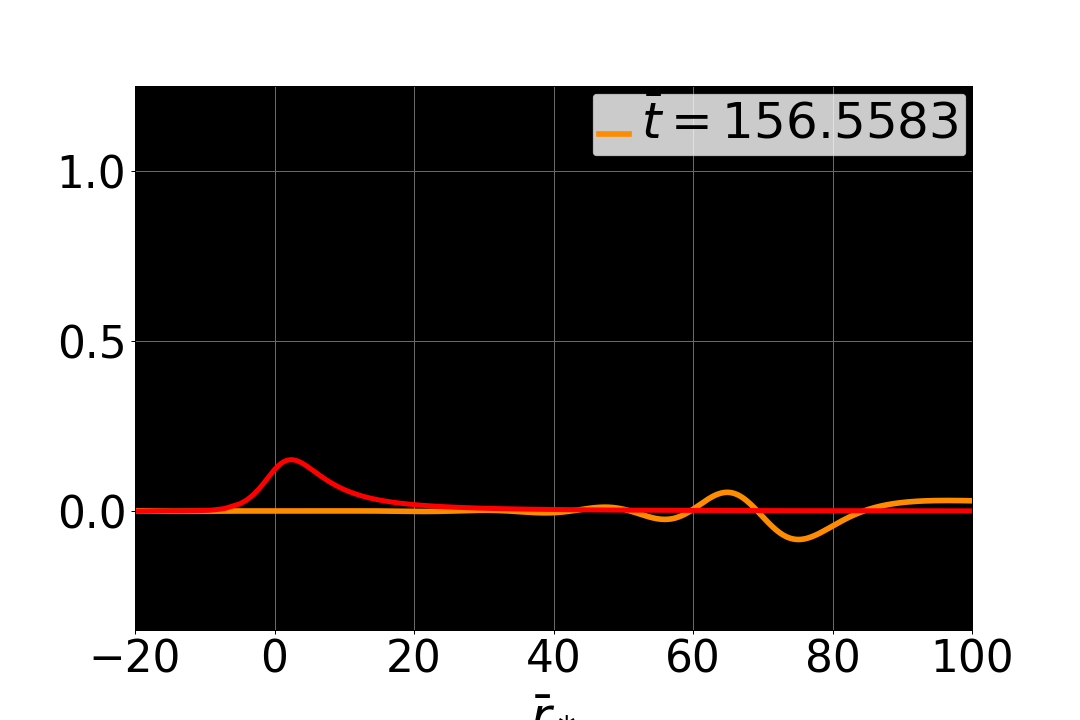

In [9]:
%matplotlib notebook
l = 2
sigma = 1
rt0 = 80
nt = 1500

ani1, ani2, RWobs, dt, rt, RWP, ZP = solveRW(l, sigma, rt0, nt)

### Regge-Wheeler equation in the logarithmic representation

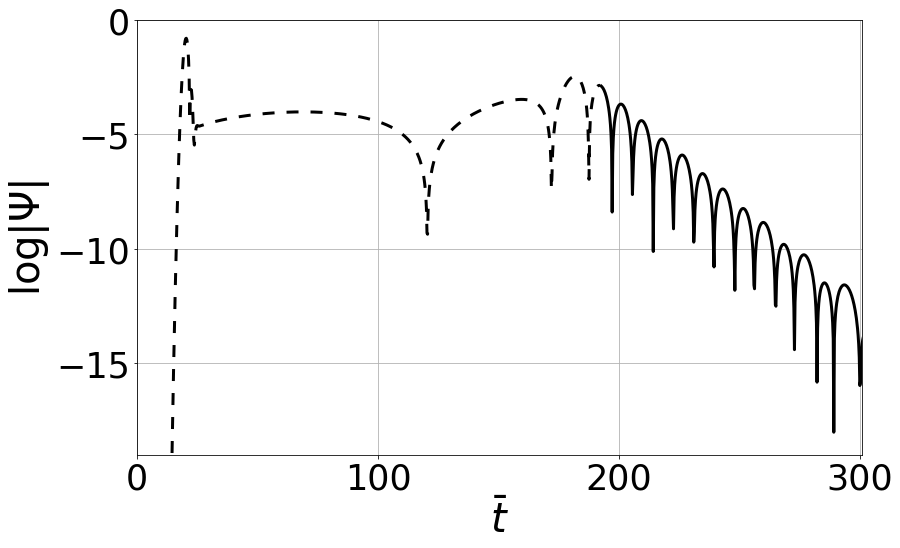

In [9]:
%matplotlib inline

t = []
for i in range(len(RWobs)):
    if RWobs[i] == 0:
        RWobs_aux = RWobs[i+1:]
        a = i+1
    else:
        break
        
t = []
log_RW=[]

for i in range(len(RWobs_aux)):
        t.append(a*dt + i * dt)
        log_RW.append(math.log(abs(RWobs_aux[i])))
        
linha_pontilhada = (4,4)        
        
plt.figure(figsize = (13, 8))      
plt.plot(t[:800], log_RW[:800], color="Black", dashes=linha_pontilhada, linewidth=3)
plt.plot(t[801:], log_RW[801:], color="Black", linewidth=3)
plt.xlim(0,301)
plt.ylim(-19,0)
plt.xlabel(r"$\bar{t}$", fontsize=40)
plt.ylabel(r"$\log|\Psi|$", fontsize=40)
plt.tick_params(axis='both', labelsize=35)
plt.grid()
#plt.savefig("Logwave_evol")


### Regge-Wheeler equation in the linear representation

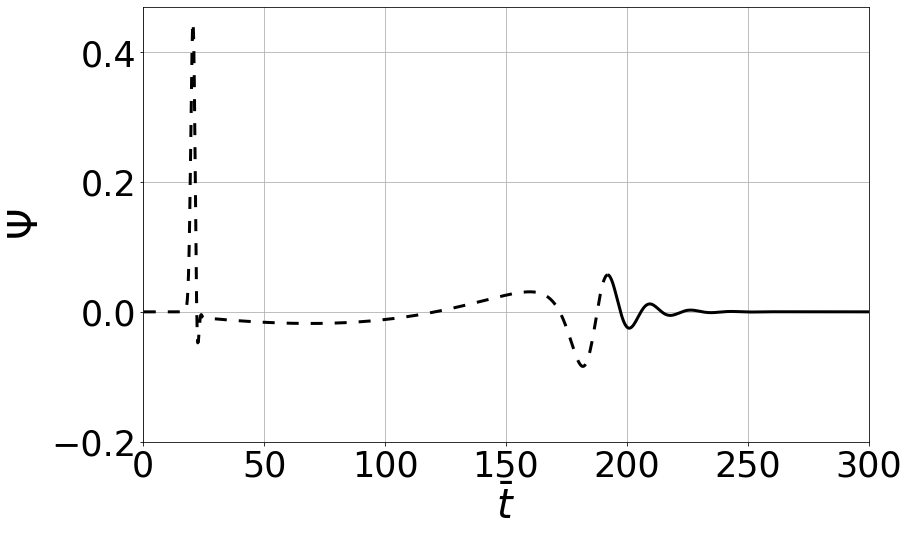

In [10]:
t2 = []

for i in range(len(RWobs)):
    t2.append(dt + i * dt)
    
linha_pontilhada = (4,4)       

plt.figure(figsize = (13, 8))    
plt.plot(t2[:800], RWobs[:800], color="Black", dashes=linha_pontilhada, linewidth=3)
plt.plot(t2[801:], RWobs[801:], color="Black",linewidth=3)
plt.xlim(0,300)
plt.ylim(-0.2,0.47)
plt.xlabel(r"$\bar{t}$", fontsize=40)
plt.ylabel(r"$\Psi$", fontsize=40)
plt.tick_params(axis='both', labelsize=35)
plt.grid()
#plt.savefig("wave_evol")

### Regge-Wheeler and Zerilli potencials

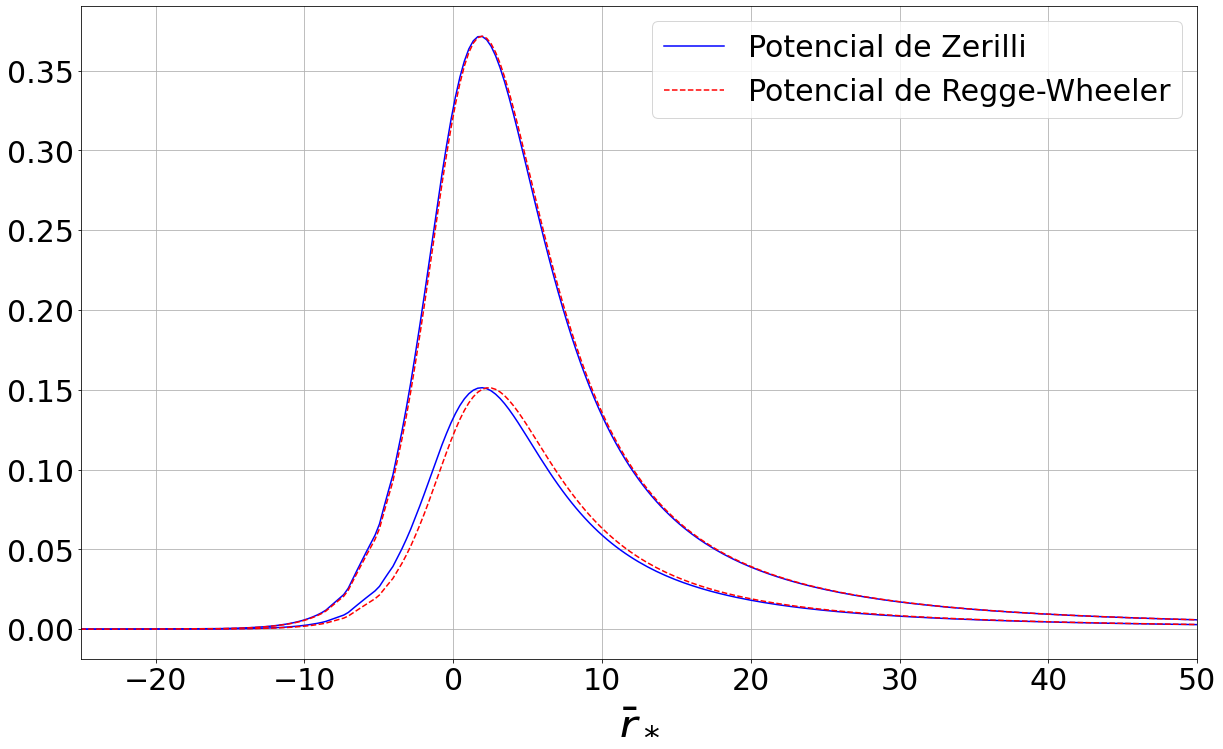

In [12]:
%matplotlib inline

r = []

plt.figure(figsize = (20, 12))
plt.plot(rt, ZP2, color="b", label='Potencial de Zerilli')
plt.plot(rt, RWP2, color="r", ls='--',label='Potencial de Regge-Wheeler')
plt.plot(rt, ZP3, color="b")
plt.plot(rt, RWP3, color="r", ls='--')
plt.xlabel(r"$\bar{r}_*$", fontsize=45)
plt.xlim(-25, 50)
plt.tick_params(axis='both', labelsize=30)
plt.legend(fontsize=30)
plt.grid()

### DFT analysis

In [1]:
def DFT(f):
    """
    Function to calculate the 
    discrete Fourier Transform 
    of a 1D real-valued signal x
    Input
    ----------
    f: array with Psi in r_obs at fixed time
    ----------
    Output
    -------
    X: DFT of f
    """

    N = len(f)
    n = np.arange(N)
    k = n.reshape((N, 1))
    e = np.exp(-2j * np.pi * k * n / N)
    
    X = np.dot(e, f)
    
    return X, n

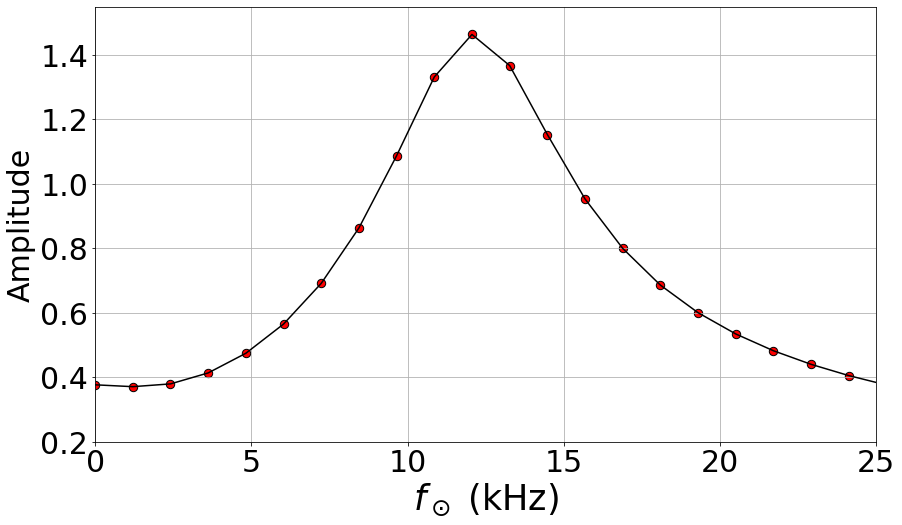

In [14]:
%matplotlib inline

X, n = DFT(RWobs[800:])

ntobs = len(X)

T = ntobs * dt
freq = ((n/T)*LightC**3/(NewtonG*MSun))/1000

NewtonG = 6.67408*10**(-8) #cm^2/g^2
LightC = 2.99792458*10**10 #cm/s
rho_dim = 2.7 * (10 ** (14)) # g^2/(s^2 * cm^2)
MSun = 1.988475415 * (10 ** 33)


plt.figure(figsize = (14, 8))
plt.xlabel(r"$f_\odot$ (kHz)", fontsize=35)
plt.plot(freq, abs(X), color='black')
plt.ylabel('Amplitude', fontsize=30)
plt.tick_params(axis='both', labelsize=30)
plt.grid()
plt.scatter(freq, abs(X), s=70, c='red', edgecolors='k')
plt.xlim(0,25)
plt.ylim(0.20,1.55)
plt.show()
#plt.savefig("AmpXFreq")

In [15]:
absX = abs(X).tolist()
absX_half = absX[:int(len(absX)/2)]
max_y = max(absX_half)

indice_y = absX.index(max_y)

freq[indice_y]

12.061574776464846

In [16]:
freq[indice_y]-freq[indice_y+1]

-1.2061574776464834

### Fit analysis

Valor ajustado para omega: -74.75528811698753
Frequência correspondente (f): -11.89767362607739
Tempo de decaimento da onda: 0.054642251860169945


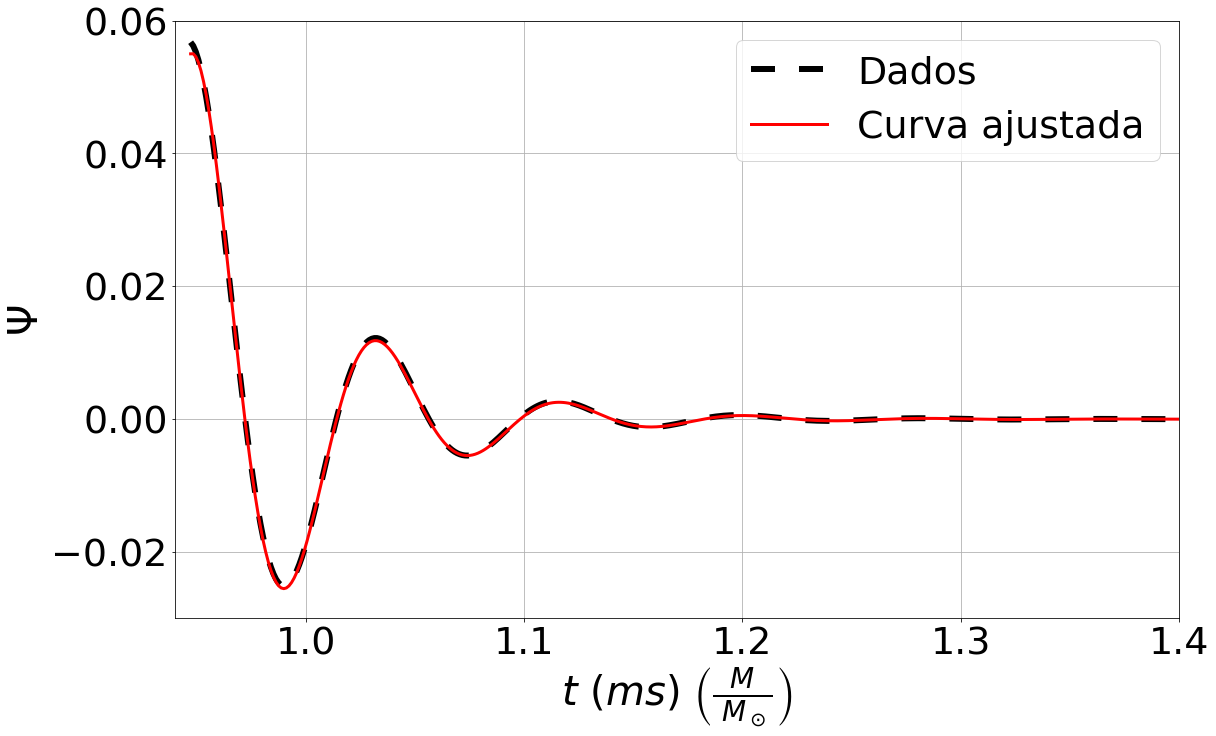

<Figure size 432x288 with 0 Axes>

In [23]:
from scipy.optimize import curve_fit

def wave_function(t, A, beta, omega, delta):
    return A * np.exp(-beta * t) * np.cos(omega * t + delta)

jin = 800
jf = 1250
Psi = np.array(RWobs[jin:jf])

ti = t2[jin]*1000/(LightC**3/(NewtonG*MSun))
tf = t2[jf]*1000/(LightC**3/(NewtonG*MSun))

t = np.linspace(ti,tf,len(Psi))

fit_params, fit_covariance = curve_fit(wave_function, t, Psi)

A_fit, beta_fit, omega_fit, delta_fit = fit_params

f = omega_fit / (2 * np.pi)

t_bar = np.linspace(t2[jin],t2[jf],len(Psi))

print("Valor ajustado para omega:", omega_fit)
print("Frequência correspondente (f):", f)
print("Tempo de decaimento da onda:", 1/beta_fit)
fig = plt.figure(figsize=(18,11))
plt.plot(t, Psi ,color='Black',label='Dados',dashes=linha_pontilhada, linewidth=6)
plt.plot(t, wave_function(t, *fit_params), 'r',label='Curva ajustada', linewidth=3)
plt.xlabel(r"$t \ (ms) \ \left(\frac{M}{\ M_\odot}\right) $", fontsize=40)
plt.ylabel(r"$\Psi$", fontsize=40)
plt.tick_params(axis='both', labelsize=38)
plt.grid()
plt.xlim(0.94,1.4)
plt.ylim(-0.03,0.06)
plt.legend(fontsize=38)
plt.show()

#plt.savefig("fitcurv.pdf")